In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  matplotlib.patches import Ellipse

from scipy.stats import chi2
from scipy.stats import t as student
from scipy.stats import f as fisher

In [2]:
df = pd.read_csv("ozone_complet.txt", sep=';').dropna()
df

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20020926,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
20020927,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
20020928,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0
20020929,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0


## 1)

In [3]:
Y = np.matrix(df.maxO3v).transpose()
Z = np.matrix([df.T12, df.Vx, df.Ne12, np.ones((Y.size,))]).transpose().astype(float)

n = Y.size
p = Z.shape[1]

Z_sharp = (Z.transpose() @ Z) ** -1 * Z.transpose()
beta_hat = Z_sharp * Y

beta_hat

matrix([[ 1.44661518],
        [ 0.88444208],
        [-1.33507028],
        [64.66754543]])

In [4]:
epsilon = Y - Z * beta_hat
sigma_hat = np.linalg.norm(epsilon) / np.sqrt(n - p)

sigma_hat

20.97181272920036

## 2)

In [5]:
def one_hot(i, n):
    a = np.zeros((n, 1))
    a[i] = 1
    return a.transpose()

def beta_interval(x_t, beta_hat, alpha):
    delta = sigma_hat * np.sqrt(x_t * ((Z.transpose() @ Z) ** -1) * x_t.transpose())
    quant = student.ppf(1 - alpha / 2, n - p)
    
    return x_t * beta_hat + delta * np.array([-quant, quant])

def sigma_2_interval(sigma_hat, alpha):
    quant = np.array([1 / chi2.ppf(1 - alpha / 2, n - p), 1 / chi2.ppf(alpha / 2, n - p)])
    return sigma_hat ** 2 * (n - p) * quant

In [6]:
alpha = .05
beta_intervals = [beta_interval(one_hot(i, p), beta_hat, alpha) for i in range(p)]
beta_intervals

[matrix([[1.18142349, 1.71180687]]),
 matrix([[0.52652976, 1.24235439]]),
 matrix([[-1.93511358, -0.73502697]]),
 matrix([[57.36033557, 71.97475529]])]

In [7]:
sigma_interval = np.sqrt(sigma_2_interval(sigma_hat, alpha))
sigma_interval

array([20.21303734, 21.79021216])

## 3)

In [8]:
def conf_ellip(A, Z, beta_hat, sigma_hat, alpha, rem_zeros=False):
    q = A.shape[0]

    Z_proj = A @ np.linalg.inv(Z.transpose() @ Z) @ A.transpose()
    if rem_zeros:
        nzero_rows = np.flatnonzero(~np.all(Z_proj == 0, axis=0))
        nzero_cols = np.flatnonzero(~np.all(Z_proj == 0, axis=1))
        Z_proj = Z_proj[nzero_rows,:]
        Z_proj = Z_proj[:, nzero_cols]

    Lambda = np.linalg.inv(Z_proj) / (q * sigma_hat ** 2)
    l, v = np.linalg.eig(Lambda)

    f1 = fisher.ppf(alpha / 2, q, n - p)
    f2 =  fisher.ppf(1 - alpha / 2, q, n - p)

    d1 = np.sqrt(f1 / l)
    d2 = np.sqrt(f2 / l)

    gamma = np.degrees(np.arctan2(v[0, 1], v[0, 0]))
    ell1 = (d1[0], d1[1], gamma)
    ell2 = (d2[0], d2[1], gamma)

    return (ell1, ell2)

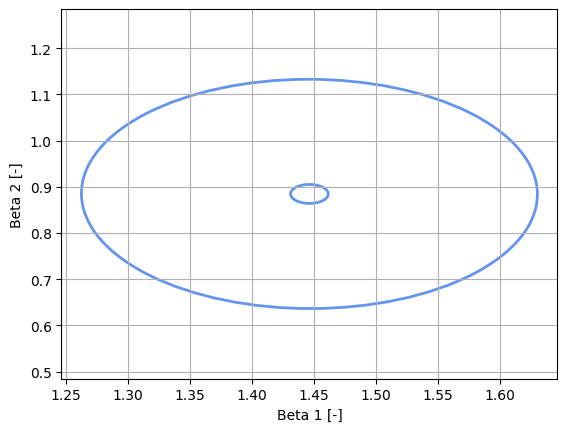

In [9]:
A = np.zeros((2, p))
A[0, 0] = 1
A[1, 1] = 1

ell1, ell2 = conf_ellip(A, Z, beta_hat, sigma_hat, alpha, rem_zeros=False)

small_obj = Ellipse(beta_hat[:2], *ell1)
large_obj = Ellipse(beta_hat[:2], *ell2)

ax = plt.gca()
ax.add_artist(small_obj)
ax.add_artist(large_obj)

small_obj.set_fill(False)
small_obj.set_edgecolor('cornflowerblue')
small_obj.set_linewidth(2)

large_obj.set_fill(False)
large_obj.set_edgecolor('cornflowerblue')
large_obj.set_linewidth(2)

ax.set_xlim(-.2 + beta_hat[0], .2 + beta_hat[0])
ax.set_ylim(-.4 + beta_hat[1], .4 + beta_hat[1])

ax.set_xlabel("Beta 1 [-]")
ax.set_ylabel("Beta 2 [-]")

ax.grid()

plt.show()

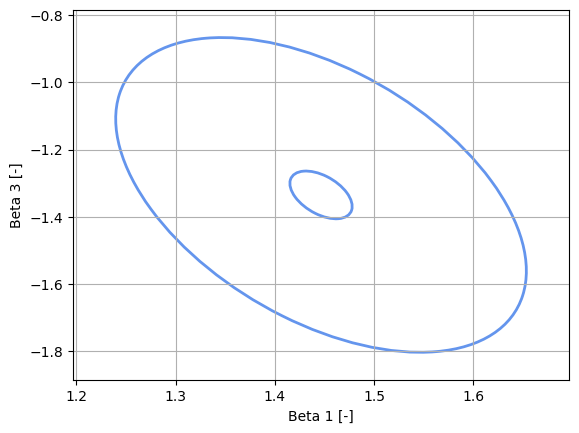

In [10]:
q = 3
A = np.zeros((q, p))
A[0, 0] = 1
A[2, 2] = 1

ell1, ell2 = conf_ellip(A, Z, beta_hat, sigma_hat, alpha, rem_zeros=True)

small_obj = Ellipse(beta_hat[[0,2]], *ell1)
large_obj = Ellipse(beta_hat[[0,2]], *ell2)

ax = plt.gca()
ax.add_artist(small_obj)
ax.add_artist(large_obj)

small_obj.set_fill(False)
small_obj.set_edgecolor('cornflowerblue')
small_obj.set_linewidth(2)

large_obj.set_fill(False)
large_obj.set_edgecolor('cornflowerblue')
large_obj.set_linewidth(2)

ax.set_xlim(-.25 + beta_hat[0], .25 + beta_hat[0])
ax.set_ylim(-.55 + beta_hat[2], .55 + beta_hat[2])

ax.set_xlabel("Beta 1 [-]")
ax.set_ylabel("Beta 3 [-]")

ax.grid()
plt.show()

## 4)
#### (i)
La question numéro (i) peut être formulé autrement comme le test d'hypothèse suivant :
$$H0 : \beta_2 = 0\text{, contre } H1 : \beta_2 \neq 0 $$
C'est à dire que nous testons si le paramètre qui multiplie $Vx$ est égal à zéro, ce qui indiquerait une non-dépendance de $O3$ par rapport à $Vx$ (une dépendance non-linéaire resterait toujours possible).
 
#### (ii)
De même, nous pouvons considérer le test suivant:
$$H0 : \beta_3 = 0\text{, contre } H1 : \beta_3 \neq 0 $$
 
 
#### (iii)
Pour vérifier l'influence par $Vx$ ou $T12$ nous pouvons considérer le test suivant:
$$H0 : (\beta_1, \beta_3) = 0\text{, contre } H1 : (\beta_1, \beta_3) \neq 0 $$
Où l'hypothèse $H0$ est l'inexistence d'une dépendance lineaire entre $O3$ et ($Vx$, $T12$)

## 5)
La procédure pour les tests (i) et (ii) découle directement de la formule de l'item 17.
 
Pour le test (iii) nous pouvons utiliser la dualité entre les tests d'hypothèse et les intervalles de confiance. C'est-à-dire, nous vérifions si la région de confiance de $(\beta_1, \beta_3)$, à niveau $\alpha$ égal à celui du test désiré, contient l'origine.

In [11]:
def test_beta(x, alpha, beta_hat, sigma_hat, Z):
    x_t = x.transpose()
    delta = sigma_hat * np.sqrt(x_t * ((Z.transpose() @ Z) ** -1) * x)
    quant = student.ppf(1 - alpha / 2, n - p)
    
    return np.abs(beta_hat.transpose() * x) > delta * quant

In [12]:
def p_valeur(x, beta_hat, sigma_hat, Z):
    x_t = x.transpose()
    delta = sigma_hat * np.sqrt(x_t * ((Z.transpose() @ Z) ** -1) * x)

    return 2 * (1 - student.cdf((np.abs(beta_hat.transpose() @ x))/(delta), n - p))

#### (i)

In [13]:
if test_beta(one_hot(1, p).transpose(), alpha, beta_hat, sigma_hat, Z):
    print("H0 rejetée.")
    print("p-valeur = " + str(p_valeur(one_hot(1, p).transpose(), beta_hat, sigma_hat, Z)[0][0]))
else:
    print("H0 acceptée.")
    print("p-valeur = " + str(p_valeur(one_hot(1, p).transpose(), beta_hat, sigma_hat, Z)[0][0]))

H0 rejetée.
p-valeur = 1.39301782864365e-06


#### (ii)

In [14]:
if test_beta(one_hot(2, p).transpose(), alpha, beta_hat, sigma_hat, Z):
    print("H0 rejetée.")
    print("p-valeur = " + str(p_valeur(one_hot(2, p).transpose(), beta_hat, sigma_hat, Z)[0][0]))
else:
    print("H0 acceptée.")
    print("p-valeur = " + str(p_valeur(one_hot(2, p).transpose(), beta_hat, sigma_hat, Z)[0][0]))

H0 rejetée.
p-valeur = 1.3690449021552809e-05


#### (iii)
Le deuxième graphique de la question pratique 3 nous montre que l'origine n'est pas comprise dans la région de confiance de $(\beta_1, \beta_3)$. Alors, nous rejetons $H0$.

## 6)
En conclusion, les tests montrent que les facteurs $Vx$, $T12$ et $N12$ influencent la valeur de $O3$.

Bien sur, ces résultats sont plausibles sous l'hypothèse que $O3$ suit un modèle gaussien linéaire dans les variables explicatives. En considérant des autres types de modèles plus complexes on pourrait arriver a des autres résultat.